<a href="https://colab.research.google.com/github/kireeti-kunam/severstal-steel-defect-detection/blob/main/final_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# reading libraries

In [ ]:
# reading and loading data

In [ ]:
# writing supporting functions:
 #(rle2mask,mask2rle) 
 # copy and paste the functions that are in  seg notebook adn binary notebook

In [ ]:
# Loading Binary model and segmodels

In [ ]:
# write for loop to predict the mask for given test image

## 1. Importing Libraries:

In [ ]:
#scikit-learn/python libraries:
#------------------------
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import math
import os
from datetime import datetime
import pickle
from glob import glob
from tqdm import tqdm
from PIL import Image


#tensor-flow and keras libraries:
#------------------------

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

Using TensorFlow backend.


<br>

## 2.Downloading and Loading Data:

#### Kaggle data files:

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/14241/862020/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1595736359&Signature=cAlXZzp1lfUnzqZ2d%2B66PDHFIGHOhfLxwkWiA9bCgmI2MTyDUcbsOxf3X2UatZWXu1uJsfDrfwX0QCU%2BpXcovy14b42%2FesOogpu407OidXt2Taim9cyjdSUwtyncLFSey0TbXISB%2BiH%2BYs2XLXkMi9fxJaOeYhKDb8Nue5R7FYhNRoXu8u9WeAedE37tUaNgO3IgXve1iwFycKMXwkfKMzlt%2BoC1xP9navyO0%2FHz08wf3LdBrH%2BLss7ZI%2FbVggW9%2F2Hxn1j1%2BoQXiRBdnDmjpT7aUff65pqG%2FW%2ByDj0mziZ%2BDouTnvg%2Fp69bWUF8P6BEvNy6pzdC1sNm9c0CnJ2hxg%3D%3D&response-content-disposition=attachment%3B+filename%3Dseverstal-steel-defect-detection.zip" -c -O 'severstal-steel-defect-detection.zip'

--2020-07-24 14:16:47--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/14241/862020/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1595736359&Signature=cAlXZzp1lfUnzqZ2d%2B66PDHFIGHOhfLxwkWiA9bCgmI2MTyDUcbsOxf3X2UatZWXu1uJsfDrfwX0QCU%2BpXcovy14b42%2FesOogpu407OidXt2Taim9cyjdSUwtyncLFSey0TbXISB%2BiH%2BYs2XLXkMi9fxJaOeYhKDb8Nue5R7FYhNRoXu8u9WeAedE37tUaNgO3IgXve1iwFycKMXwkfKMzlt%2BoC1xP9navyO0%2FHz08wf3LdBrH%2BLss7ZI%2FbVggW9%2F2Hxn1j1%2BoQXiRBdnDmjpT7aUff65pqG%2FW%2ByDj0mziZ%2BDouTnvg%2Fp69bWUF8P6BEvNy6pzdC1sNm9c0CnJ2hxg%3D%3D&response-content-disposition=attachment%3B+filename%3Dseverstal-steel-defect-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already ful

In [ ]:
## unzipping the data files:

from zipfile import ZipFile
with ZipFile('severstal-steel-defect-detection.zip', 'r') as zf:
    zf.extractall('case_study_2_data/')

In [ ]:
test_images = glob('/content/case_study_2_data/test_images/*.jpg')
print("we have {0} test images".format(len(test_images)))

we have 5506 test images


#### Google drive data files:

In [ ]:
## Mounting google drive:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<br>

<br>

## 3. Supporting functions:

### 3.1 Bianry model supporting functions:

In [ ]:
# resizing and normalizing the test image for binary classification and segmentation also:

@tf.function
def val_image_resize(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 800])

    return image



### 3.2 Segmentation model supporting functions:

In [ ]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


@tf.function
def DiceLoss(y_true,y_pred):

  smooth = 1e-6
  intersection = tf.reduce_sum(y_true * y_pred)
  dice_score = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
  dice_score = tf.cast(dice_score,'float32')
  
  return 1.0 - dice_score

@tf.function
def Dicecoef(y_true,y_pred):
  
  smooth = 1
  intersection = tf.reduce_sum(y_true * y_pred)
  dice_score = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
  dice_score = tf.cast(dice_score,'float32')
  
  return dice_score

@tf.function
def Bce_dice_loss(y_true, y_predict): #combination of dice loss and binary cross entropy for all pixels
    return binary_crossentropy(y_true, y_predict) + (1-Dicecoef(y_true, y_predict))

## 4. Loading our models(Binary & segmentation):

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True



# loading binary model:
Binary_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/binary_model/cp.ckpt/')
print("Binary model loaded")


# loading segmentation model:
defect_1_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_1/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})
print("Seg model_1 loaded")


defect_2_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_2/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})
print("Seg model_2 loaded")


defect_3_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_3/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})
print("Seg model_3 loaded")


defect_4_model = tf.keras.models.load_model('/content/drive/My Drive/seg_models/defect_4/cp.ckpt/',
                                            custom_objects={'Bce_dice_loss':Bce_dice_loss,'Dicecoef':Dicecoef})
print("Seg model_4 loaded")

Binary model loaded
Seg model_1 loaded
Seg model_2 loaded
Seg model_3 loaded
Seg model_4 loaded


### Building final pipeline:

In [ ]:
df = pd.DataFrame(columns=['ImageId_ClassId','EncodedPixels'])

for test_sample in tqdm(sample_test_6['Images']):

  img_id_1 = os.path.split(test_sample)[1]+'_1' # ex: abc.jpg_1
  img_id_2 = os.path.split(test_sample)[1]+'_2' # ex: abc.jpg_2
  img_id_3 = os.path.split(test_sample)[1]+'_3' # ex: abc.jpg_3
  img_id_4 = os.path.split(test_sample)[1]+'_4' # ex: abc.jpg_4

  image = val_image_resize(test_sample)
  image_reshaped = np.expand_dims(image,axis=0)

  if Binary_model.predict(image_reshaped)>0.5:

    predicted_mask_1 = defect_1_model.predict(image_reshaped)
    predicted_mask_1 = np.squeeze(predicted_mask_1, axis=-1)
    predicted_mask_1 = np.squeeze(predicted_mask_1, axis=0)
    predicted_mask_1 = Image.fromarray(predicted_mask_1)
    rle_1            = mask2rle(np.array(predicted_mask_1.resize((1600,256)))>0.5)

    predicted_mask_2 = defect_2_model.predict(image_reshaped)
    predicted_mask_2 = np.squeeze(predicted_mask_2, axis=-1)
    predicted_mask_2 = np.squeeze(predicted_mask_2, axis=0)
    predicted_mask_2 = Image.fromarray(predicted_mask_2)
    rle_2            = mask2rle(np.array(predicted_mask_2.resize((1600,256)))>0.5)

    predicted_mask_3 = defect_3_model.predict(image_reshaped)
    predicted_mask_3 = np.squeeze(predicted_mask_3, axis=-1)
    predicted_mask_3 = np.squeeze(predicted_mask_3, axis=0)
    predicted_mask_3 = Image.fromarray(predicted_mask_3)
    rle_3            = mask2rle(np.array(predicted_mask_3.resize((1600,256)))>0.5)

    predicted_mask_4 = defect_4_model.predict(image_reshaped)
    predicted_mask_4 = np.squeeze(predicted_mask_4, axis=-1)
    predicted_mask_4 = np.squeeze(predicted_mask_4, axis=0)
    predicted_mask_4 = Image.fromarray(predicted_mask_4)
    rle_4            = mask2rle(np.array(predicted_mask_4.resize((1600,256)))>0.5)
    

  else:
    rle_1 = ""
    rle_2 = ""
    rle_3 = ""
    rle_4 = ""
  

  new_row_1=[img_id_1,rle_1]
  new_row_2=[img_id_2,rle_2]
  new_row_3=[img_id_3,rle_3]
  new_row_4=[img_id_4,rle_4]

  df_length = len(df)
    
  df.loc[df_length]   = new_row_1
  df.loc[df_length+1] = new_row_2
  df.loc[df_length+2] = new_row_3
  df.loc[df_length+3] = new_row_4

100%|██████████| 505/505 [01:49<00:00,  4.63it/s]


In [ ]:
final_predictions = df 

In [ ]:
final_predictions.to_pickle("/content/drive/My Drive/seg_models/final_predictions.pkl")

In [ ]:
final_predictions.to_csv("/content/drive/My Drive/seg_models/final_predictions.csv")

In [ ]:
final_predictions.head()

,ImageId_ClassId,EncodedPixels
0,0d8ba3c7a.jpg_1,
1,0d8ba3c7a.jpg_2,
2,0d8ba3c7a.jpg_3,
3,0d8ba3c7a.jpg_4,
4,89cc16612.jpg_1,


#### submission in kaggle:

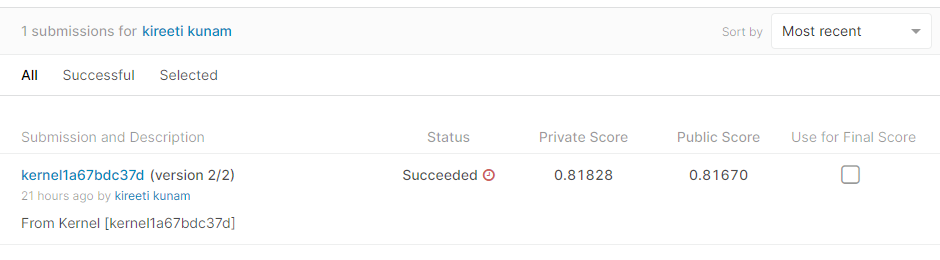

In [ ]:
from IPython.display import Image
Image(filename='/content/Screenshot (148).png')